In [1]:
# Install if necessary:
# !pip install tensorflow matplotlib numpy pillow

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-07-05 13:32:24.314843: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 13:32:24.627535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751702544.784477    1156 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751702544.822979    1156 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751702545.047646    1156 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Path to your training directory (with Happy, Sad, etc.)
train_dir = "AffectNet/train/"  # <-- update this

IMG_SIZE = 64
BATCH_SIZE = 64
NUM_CLASSES = 4  # Happy, Sad, Surprised, Mad

datagen = ImageDataGenerator(rescale=1./127.5, preprocessing_function=lambda x: x - 1.0)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

label_names = list(train_data.class_indices.keys())
print("Class labels:", label_names)


Found 8000 images belonging to 4 classes.
Class labels: ['Happy', 'Mad', 'Sad', 'Surprised']


In [4]:
def build_generator(z_dim, num_classes):
    noise_input = layers.Input(shape=(z_dim,))
    label_input = layers.Input(shape=(num_classes,))

    x = layers.Concatenate()([noise_input, label_input])
    x = layers.Dense(8 * 8 * 256, use_bias=False)(x)
    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(3, 5, strides=2, padding='same', activation='tanh')(x)

    model = tf.keras.Model([noise_input, label_input], x)
    return model


In [3]:
def build_discriminator(img_shape, num_classes):
    image_input = layers.Input(shape=img_shape)
    label_input = layers.Input(shape=(num_classes,))

    label_map = layers.Dense(img_shape[0] * img_shape[1] * 1)(label_input)
    label_map = layers.Reshape((img_shape[0], img_shape[1], 1))(label_map)

    x = layers.Concatenate()([image_input, label_map])
    x = layers.Conv2D(64, 5, strides=2, padding='same', activation='leaky_relu')(x)
    x = layers.Conv2D(128, 5, strides=2, padding='same', activation='leaky_relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    model = tf.keras.Model([image_input, label_input], x)
    return model


In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
z_dim = 100

generator = build_generator(z_dim, NUM_CLASSES)
discriminator = build_discriminator((IMG_SIZE, IMG_SIZE, 3), NUM_CLASSES)

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)


I0000 00:00:1751703209.492713    1156 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, z_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss



Epoch 1/200


I0000 00:00:1751703227.319195    1786 cuda_dnn.cc:529] Loaded cuDNN version 90800


  Generator Loss: 0.6056 | Discriminator Loss: 0.7959

Epoch 2/200
  Generator Loss: 0.6146 | Discriminator Loss: 0.8724

Epoch 3/200
  Generator Loss: 2.5043 | Discriminator Loss: 0.1189

Epoch 4/200
  Generator Loss: 1.7268 | Discriminator Loss: 0.2412

Epoch 5/200
  Generator Loss: 2.5958 | Discriminator Loss: 0.1035

Epoch 6/200
  Generator Loss: 5.3670 | Discriminator Loss: 0.0432

Epoch 7/200
  Generator Loss: 4.1918 | Discriminator Loss: 0.0783

Epoch 8/200
  Generator Loss: 4.4444 | Discriminator Loss: 0.0230

Epoch 9/200
  Generator Loss: 4.2383 | Discriminator Loss: 0.0384

Epoch 10/200
  Generator Loss: 4.6708 | Discriminator Loss: 0.0100


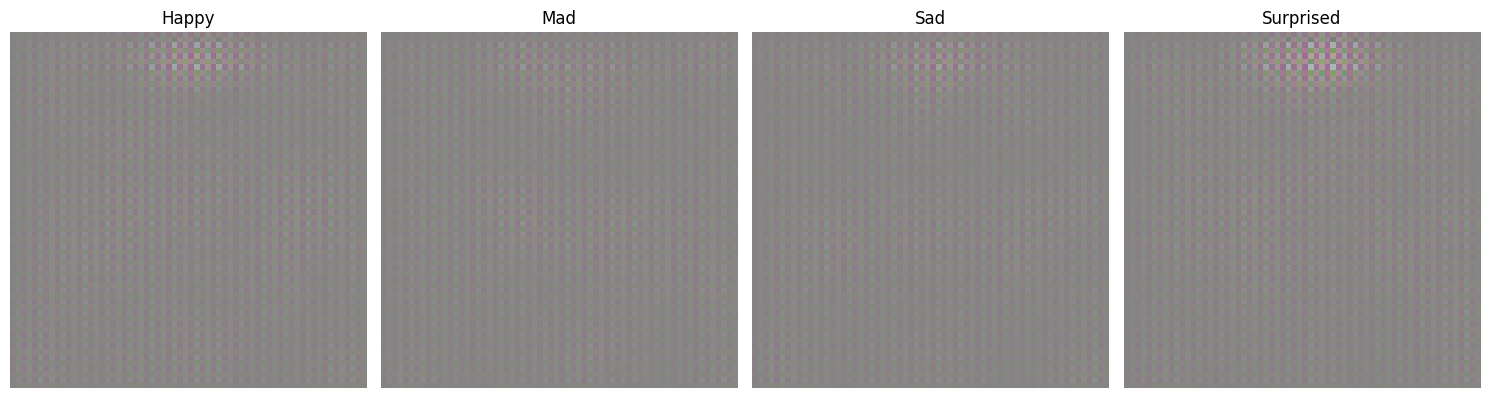


Epoch 11/200
  Generator Loss: 4.4692 | Discriminator Loss: 0.0236

Epoch 12/200
  Generator Loss: 5.0282 | Discriminator Loss: 0.1014

Epoch 13/200
  Generator Loss: 3.7566 | Discriminator Loss: 0.1280

Epoch 14/200
  Generator Loss: 2.0803 | Discriminator Loss: 0.5693

Epoch 15/200
  Generator Loss: 5.2415 | Discriminator Loss: 0.1282

Epoch 16/200
  Generator Loss: 3.1027 | Discriminator Loss: 0.3874

Epoch 17/200
  Generator Loss: 4.4348 | Discriminator Loss: 0.1609

Epoch 18/200
  Generator Loss: 3.8251 | Discriminator Loss: 0.3142

Epoch 19/200
  Generator Loss: 3.1040 | Discriminator Loss: 0.3438

Epoch 20/200
  Generator Loss: 2.3261 | Discriminator Loss: 0.6303


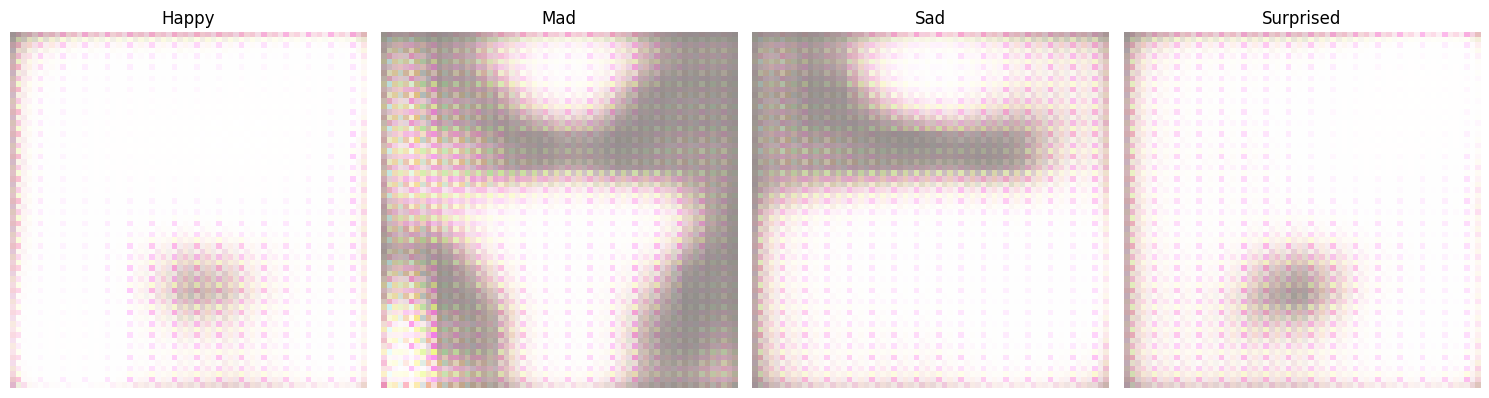


Epoch 21/200
  Generator Loss: 1.7872 | Discriminator Loss: 0.4238

Epoch 22/200
  Generator Loss: 2.9470 | Discriminator Loss: 0.3788

Epoch 23/200
  Generator Loss: 5.1167 | Discriminator Loss: 0.2619

Epoch 24/200
  Generator Loss: 4.6468 | Discriminator Loss: 0.1051

Epoch 25/200
  Generator Loss: 3.0513 | Discriminator Loss: 0.2314

Epoch 26/200
  Generator Loss: 2.8961 | Discriminator Loss: 0.3041

Epoch 27/200
  Generator Loss: 1.1734 | Discriminator Loss: 0.7825

Epoch 28/200
  Generator Loss: 2.2966 | Discriminator Loss: 0.7173

Epoch 29/200
  Generator Loss: 3.1361 | Discriminator Loss: 0.2362

Epoch 30/200
  Generator Loss: 2.4330 | Discriminator Loss: 0.2639


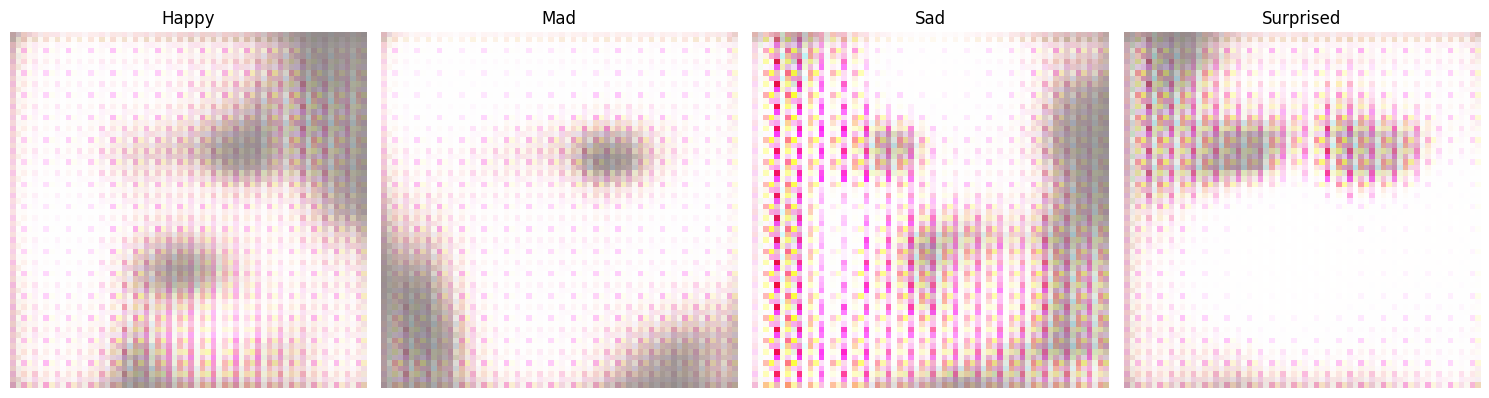


Epoch 31/200
  Generator Loss: 3.4859 | Discriminator Loss: 0.3168

Epoch 32/200
  Generator Loss: 2.4871 | Discriminator Loss: 0.6072

Epoch 33/200
  Generator Loss: 1.5237 | Discriminator Loss: 0.8272

Epoch 34/200
  Generator Loss: 2.9715 | Discriminator Loss: 0.3188

Epoch 35/200
  Generator Loss: 3.2800 | Discriminator Loss: 0.5458

Epoch 36/200
  Generator Loss: 3.2407 | Discriminator Loss: 0.3469

Epoch 37/200
  Generator Loss: 2.9695 | Discriminator Loss: 0.5850

Epoch 38/200
  Generator Loss: 2.6754 | Discriminator Loss: 0.6450

Epoch 39/200
  Generator Loss: 2.1921 | Discriminator Loss: 0.9275

Epoch 40/200
  Generator Loss: 2.8153 | Discriminator Loss: 0.4584


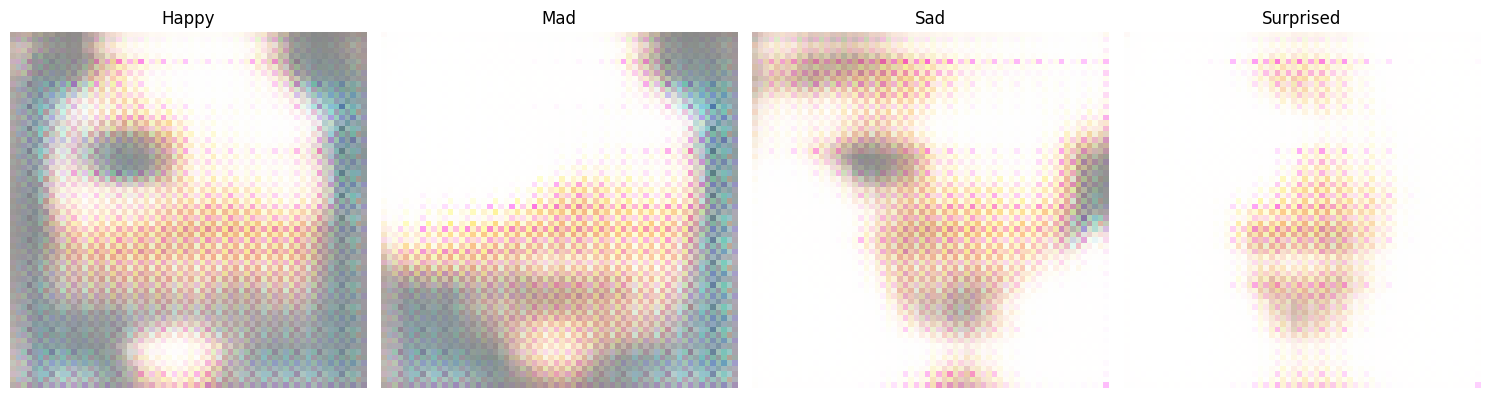


Epoch 41/200
  Generator Loss: 2.0296 | Discriminator Loss: 0.5185

Epoch 42/200
  Generator Loss: 2.8929 | Discriminator Loss: 0.6420

Epoch 43/200
  Generator Loss: 2.7322 | Discriminator Loss: 0.4119

Epoch 44/200
  Generator Loss: 1.7554 | Discriminator Loss: 0.5564

Epoch 45/200
  Generator Loss: 2.2671 | Discriminator Loss: 0.4308

Epoch 46/200
  Generator Loss: 2.6090 | Discriminator Loss: 0.4595

Epoch 47/200
  Generator Loss: 1.8090 | Discriminator Loss: 0.7619

Epoch 48/200
  Generator Loss: 2.0520 | Discriminator Loss: 0.3661

Epoch 49/200
  Generator Loss: 1.5849 | Discriminator Loss: 0.7405

Epoch 50/200
  Generator Loss: 2.6844 | Discriminator Loss: 0.4915


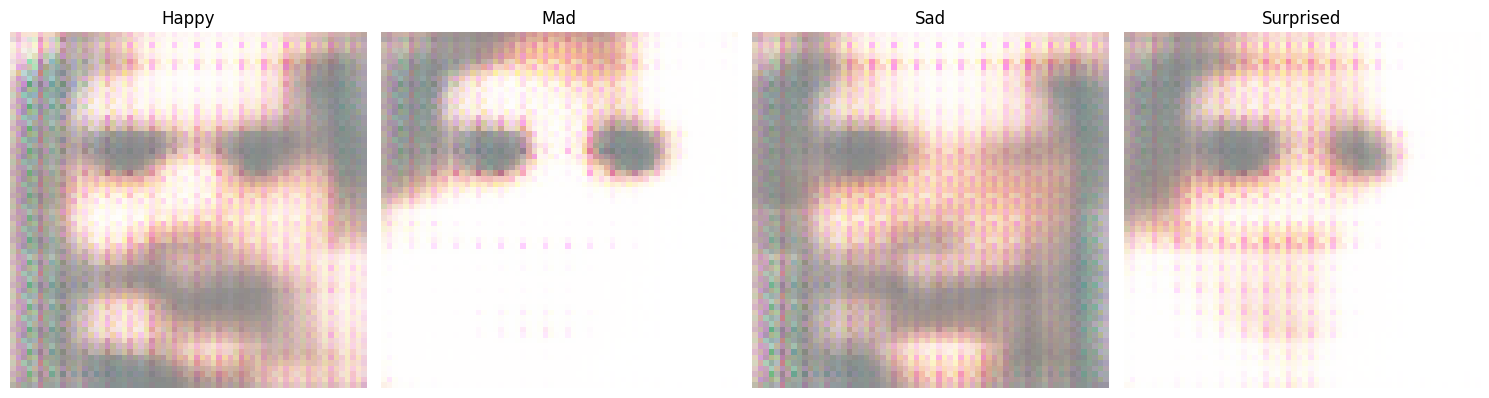


Epoch 51/200
  Generator Loss: 2.1861 | Discriminator Loss: 0.2809

Epoch 52/200
  Generator Loss: 1.1691 | Discriminator Loss: 0.7895

Epoch 53/200
  Generator Loss: 2.2621 | Discriminator Loss: 0.1854

Epoch 54/200
  Generator Loss: 2.3908 | Discriminator Loss: 0.2342

Epoch 55/200
  Generator Loss: 2.6064 | Discriminator Loss: 0.5246

Epoch 56/200
  Generator Loss: 2.7499 | Discriminator Loss: 0.2800

Epoch 57/200
  Generator Loss: 2.2406 | Discriminator Loss: 0.4168

Epoch 58/200
  Generator Loss: 2.9677 | Discriminator Loss: 0.3773

Epoch 59/200
  Generator Loss: 2.3530 | Discriminator Loss: 0.3866

Epoch 60/200
  Generator Loss: 3.0220 | Discriminator Loss: 0.2967


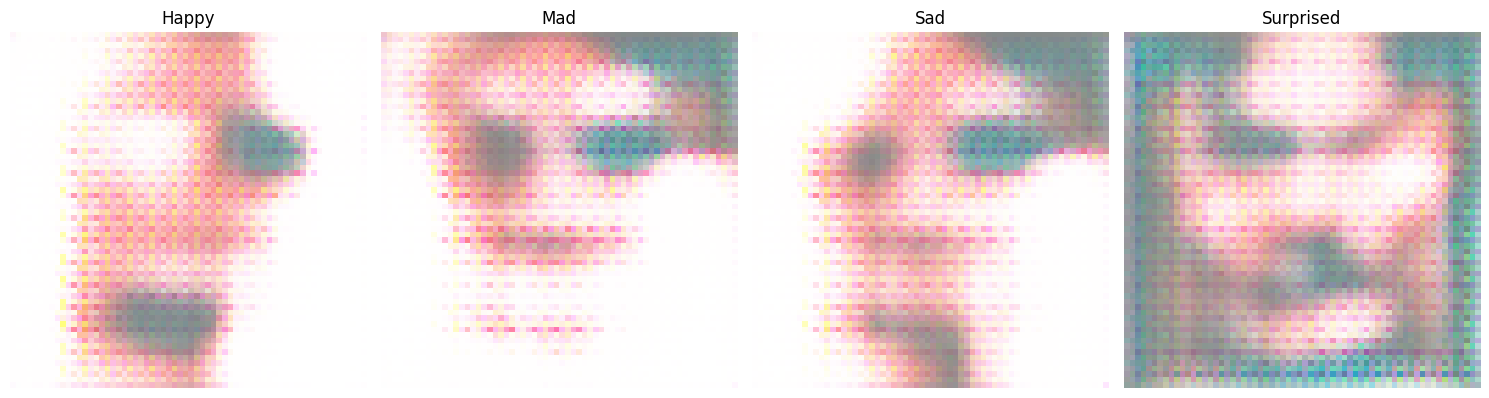


Epoch 61/200
  Generator Loss: 3.8058 | Discriminator Loss: 0.2825

Epoch 62/200
  Generator Loss: 2.5721 | Discriminator Loss: 0.4896

Epoch 63/200
  Generator Loss: 2.2191 | Discriminator Loss: 0.3789

Epoch 64/200
  Generator Loss: 2.6227 | Discriminator Loss: 0.4965

Epoch 65/200
  Generator Loss: 2.6182 | Discriminator Loss: 0.5583

Epoch 66/200
  Generator Loss: 3.0063 | Discriminator Loss: 0.2167

Epoch 67/200
  Generator Loss: 2.3918 | Discriminator Loss: 0.3355

Epoch 68/200
  Generator Loss: 2.7678 | Discriminator Loss: 0.3628

Epoch 69/200
  Generator Loss: 2.0910 | Discriminator Loss: 0.4346

Epoch 70/200
  Generator Loss: 2.6541 | Discriminator Loss: 0.4011


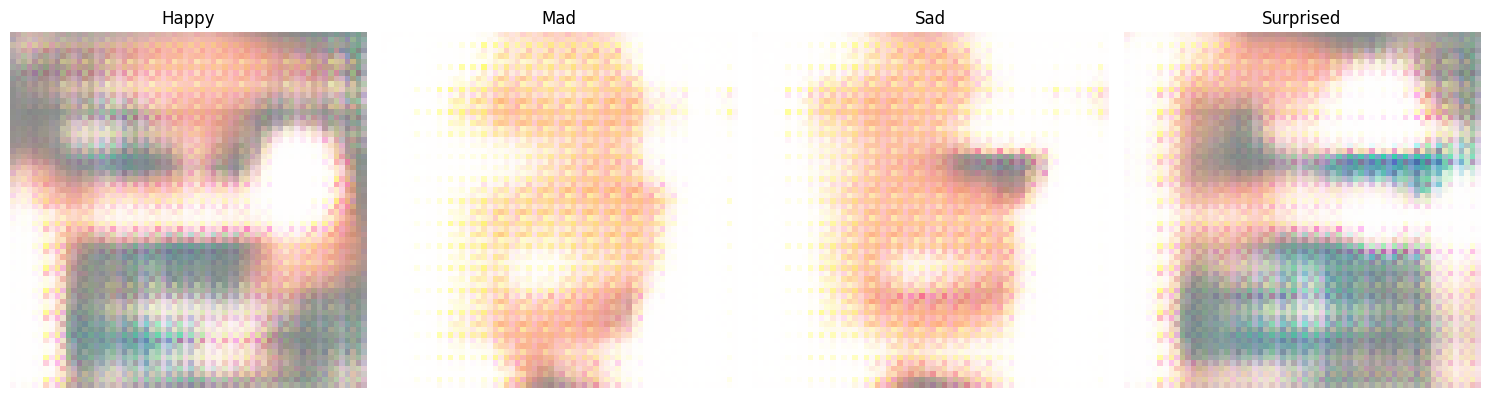


Epoch 71/200
  Generator Loss: 2.7379 | Discriminator Loss: 0.2106

Epoch 72/200
  Generator Loss: 2.5602 | Discriminator Loss: 0.3887

Epoch 73/200
  Generator Loss: 2.5466 | Discriminator Loss: 0.2831

Epoch 74/200
  Generator Loss: 2.4702 | Discriminator Loss: 0.2686

Epoch 75/200
  Generator Loss: 2.6832 | Discriminator Loss: 0.2058

Epoch 76/200
  Generator Loss: 1.9285 | Discriminator Loss: 0.2625

Epoch 77/200
  Generator Loss: 2.1798 | Discriminator Loss: 0.2154

Epoch 78/200
  Generator Loss: 2.6762 | Discriminator Loss: 0.1874

Epoch 79/200
  Generator Loss: 2.4554 | Discriminator Loss: 0.2949

Epoch 80/200
  Generator Loss: 2.4468 | Discriminator Loss: 0.2186


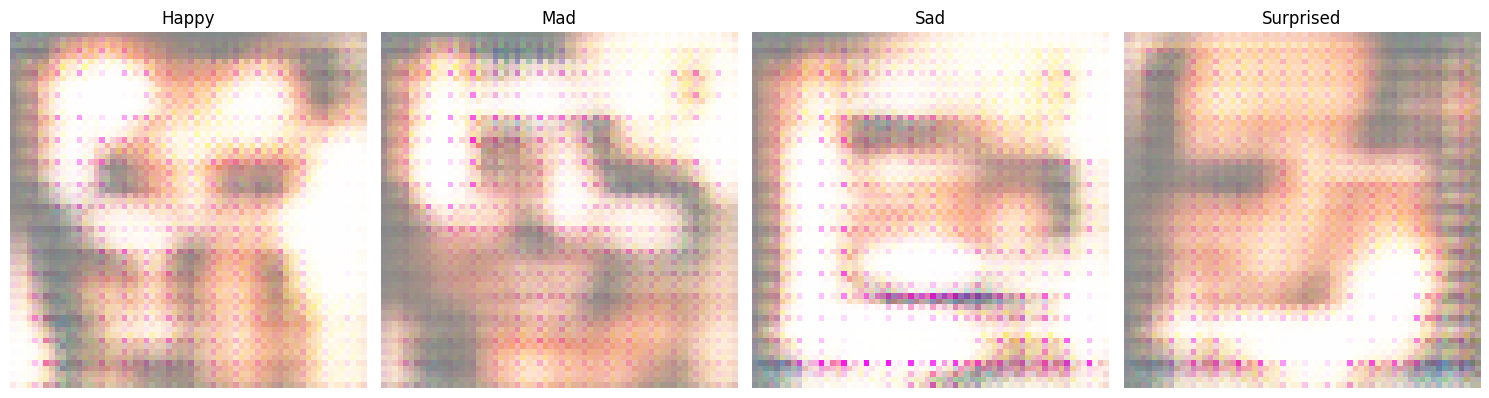


Epoch 81/200
  Generator Loss: 2.8524 | Discriminator Loss: 0.2268

Epoch 82/200
  Generator Loss: 3.1291 | Discriminator Loss: 0.4228

Epoch 83/200
  Generator Loss: 2.2090 | Discriminator Loss: 0.4444

Epoch 84/200
  Generator Loss: 3.1912 | Discriminator Loss: 0.1325

Epoch 85/200
  Generator Loss: 2.3319 | Discriminator Loss: 0.3177

Epoch 86/200
  Generator Loss: 2.6703 | Discriminator Loss: 0.1834

Epoch 87/200
  Generator Loss: 2.6895 | Discriminator Loss: 0.2577

Epoch 88/200
  Generator Loss: 2.8313 | Discriminator Loss: 0.2212

Epoch 89/200
  Generator Loss: 2.8239 | Discriminator Loss: 0.2023

Epoch 90/200
  Generator Loss: 2.2056 | Discriminator Loss: 0.3981


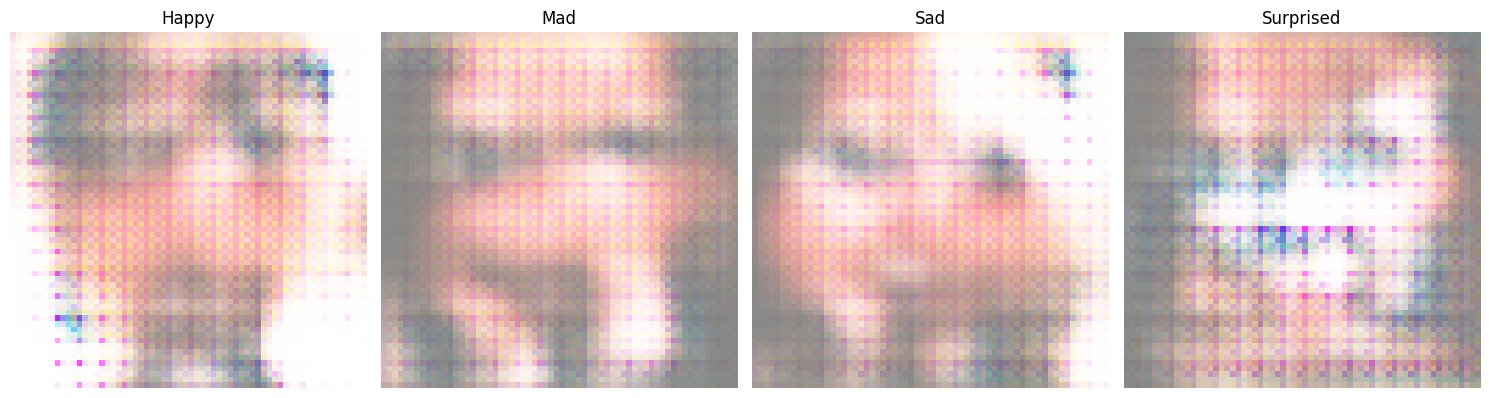


Epoch 91/200
  Generator Loss: 2.8595 | Discriminator Loss: 0.1290

Epoch 92/200
  Generator Loss: 2.6812 | Discriminator Loss: 0.2578

Epoch 93/200
  Generator Loss: 3.4689 | Discriminator Loss: 0.2753

Epoch 94/200
  Generator Loss: 3.0555 | Discriminator Loss: 0.3173

Epoch 95/200
  Generator Loss: 3.4446 | Discriminator Loss: 0.1308

Epoch 96/200
  Generator Loss: 2.4399 | Discriminator Loss: 0.2160

Epoch 97/200
  Generator Loss: 3.0106 | Discriminator Loss: 0.1630

Epoch 98/200
  Generator Loss: 2.8857 | Discriminator Loss: 0.3272

Epoch 99/200
  Generator Loss: 3.2021 | Discriminator Loss: 0.3577

Epoch 100/200
  Generator Loss: 3.0052 | Discriminator Loss: 0.3374


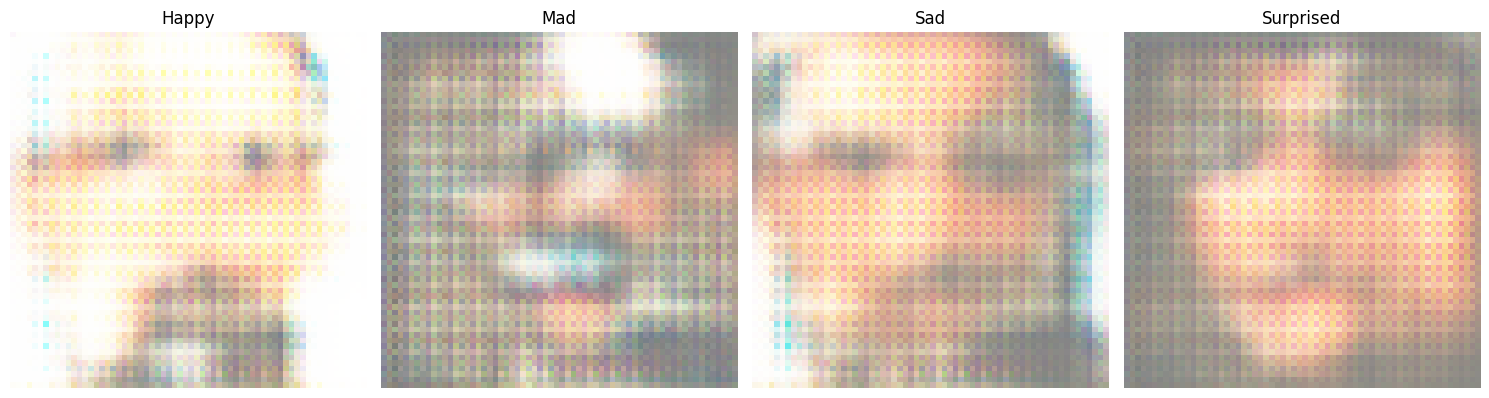


Epoch 101/200
  Generator Loss: 3.2625 | Discriminator Loss: 0.1492

Epoch 102/200
  Generator Loss: 3.3755 | Discriminator Loss: 0.2499

Epoch 103/200
  Generator Loss: 2.6639 | Discriminator Loss: 0.1881

Epoch 104/200
  Generator Loss: 2.7257 | Discriminator Loss: 0.2614

Epoch 105/200
  Generator Loss: 4.3933 | Discriminator Loss: 0.4745

Epoch 106/200
  Generator Loss: 3.0752 | Discriminator Loss: 0.2471

Epoch 107/200
  Generator Loss: 2.9814 | Discriminator Loss: 0.0904

Epoch 108/200
  Generator Loss: 3.3918 | Discriminator Loss: 0.1997

Epoch 109/200
  Generator Loss: 3.1007 | Discriminator Loss: 0.0678

Epoch 110/200
  Generator Loss: 3.4647 | Discriminator Loss: 0.0581


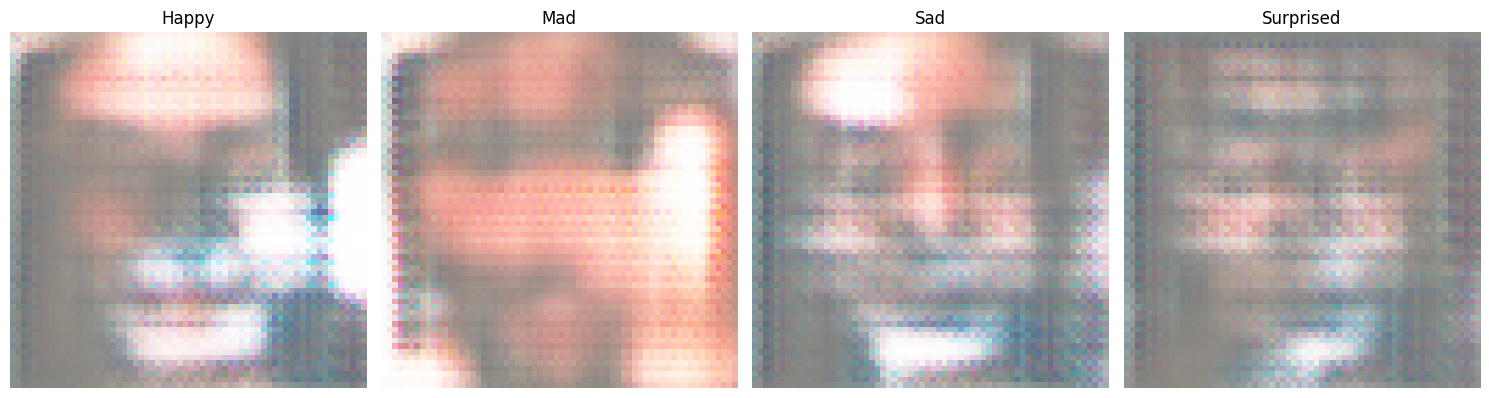


Epoch 111/200
  Generator Loss: 2.6754 | Discriminator Loss: 0.1642

Epoch 112/200
  Generator Loss: 3.7790 | Discriminator Loss: 0.2743

Epoch 113/200
  Generator Loss: 3.3450 | Discriminator Loss: 0.2336

Epoch 114/200
  Generator Loss: 3.2324 | Discriminator Loss: 0.2555

Epoch 115/200
  Generator Loss: 3.8939 | Discriminator Loss: 0.0516

Epoch 116/200
  Generator Loss: 2.8889 | Discriminator Loss: 0.2036

Epoch 117/200
  Generator Loss: 3.3360 | Discriminator Loss: 0.1290

Epoch 118/200
  Generator Loss: 2.7458 | Discriminator Loss: 0.3432

Epoch 119/200
  Generator Loss: 2.6698 | Discriminator Loss: 0.4334

Epoch 120/200
  Generator Loss: 3.2730 | Discriminator Loss: 0.1180


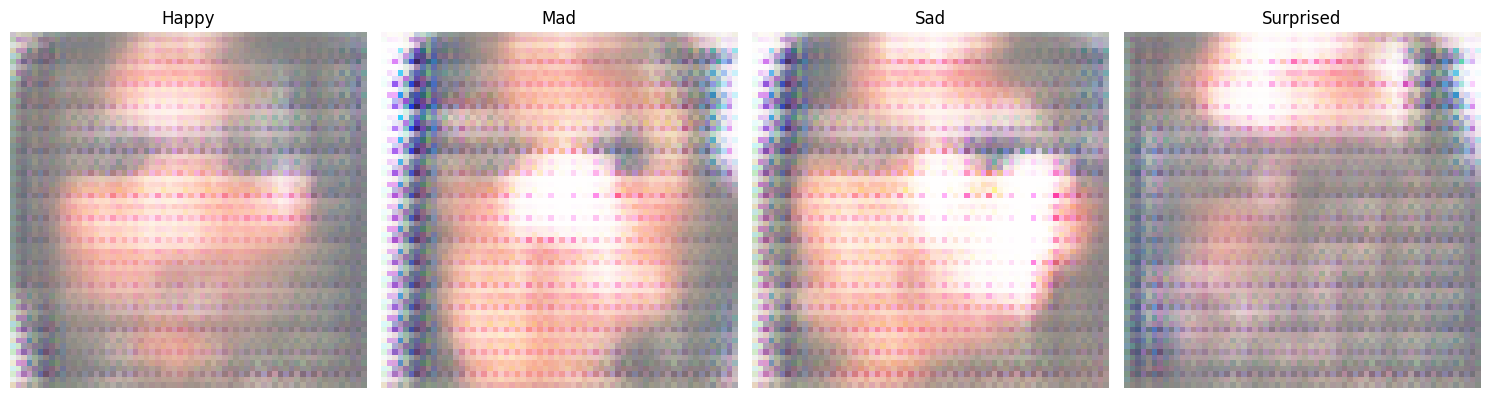


Epoch 121/200
  Generator Loss: 3.1682 | Discriminator Loss: 0.2292

Epoch 122/200
  Generator Loss: 3.0174 | Discriminator Loss: 0.2269

Epoch 123/200
  Generator Loss: 3.3440 | Discriminator Loss: 0.1957

Epoch 124/200
  Generator Loss: 3.4844 | Discriminator Loss: 0.1929

Epoch 125/200
  Generator Loss: 3.0010 | Discriminator Loss: 0.1409

Epoch 126/200
  Generator Loss: 2.9321 | Discriminator Loss: 0.2753

Epoch 127/200
  Generator Loss: 3.1741 | Discriminator Loss: 0.1343

Epoch 128/200
  Generator Loss: 3.1065 | Discriminator Loss: 0.2945

Epoch 129/200
  Generator Loss: 3.3619 | Discriminator Loss: 0.1753

Epoch 130/200
  Generator Loss: 3.2143 | Discriminator Loss: 0.3052


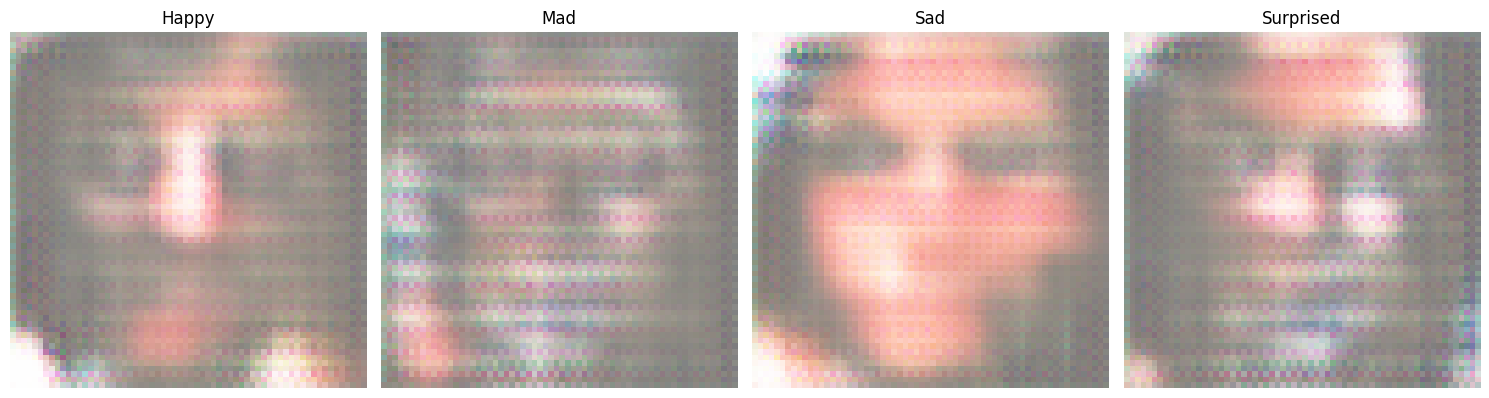


Epoch 131/200
  Generator Loss: 3.1255 | Discriminator Loss: 0.1193

Epoch 132/200
  Generator Loss: 3.4741 | Discriminator Loss: 0.2265

Epoch 133/200
  Generator Loss: 3.7616 | Discriminator Loss: 0.2158

Epoch 134/200
  Generator Loss: 3.7394 | Discriminator Loss: 0.2119

Epoch 135/200
  Generator Loss: 3.5942 | Discriminator Loss: 0.1787

Epoch 136/200
  Generator Loss: 3.3801 | Discriminator Loss: 0.1533

Epoch 137/200
  Generator Loss: 3.6485 | Discriminator Loss: 0.2856

Epoch 138/200
  Generator Loss: 3.9575 | Discriminator Loss: 0.1715

Epoch 139/200
  Generator Loss: 3.7502 | Discriminator Loss: 0.2059

Epoch 140/200
  Generator Loss: 3.7562 | Discriminator Loss: 0.3251


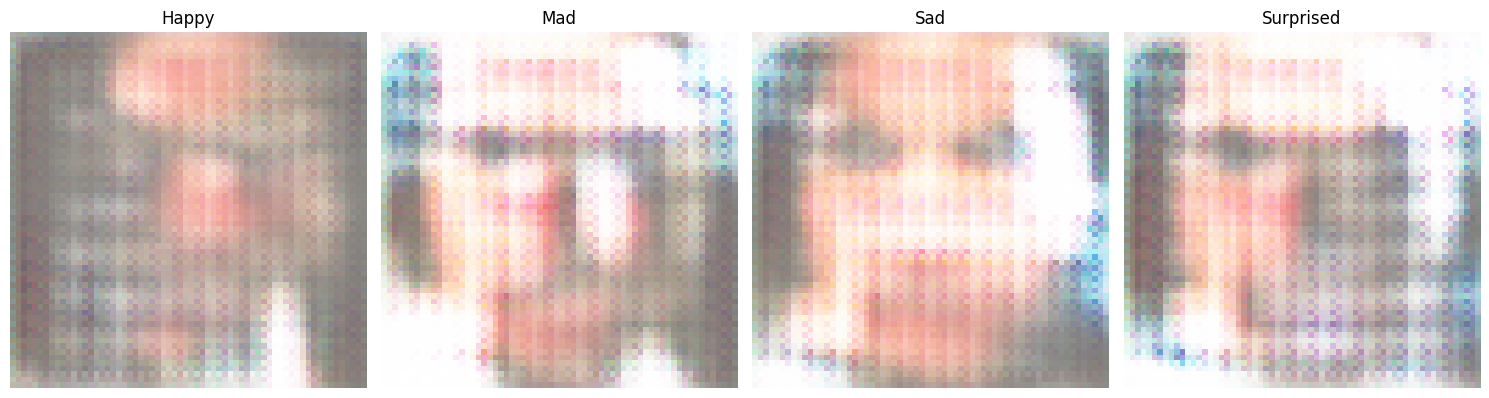


Epoch 141/200
  Generator Loss: 4.6266 | Discriminator Loss: 0.2381

Epoch 142/200
  Generator Loss: 3.2091 | Discriminator Loss: 0.1081

Epoch 143/200
  Generator Loss: 3.2377 | Discriminator Loss: 0.1615

Epoch 144/200
  Generator Loss: 3.4365 | Discriminator Loss: 0.2016

Epoch 145/200
  Generator Loss: 3.7557 | Discriminator Loss: 0.1633

Epoch 146/200
  Generator Loss: 2.6771 | Discriminator Loss: 0.1098

Epoch 147/200
  Generator Loss: 3.4578 | Discriminator Loss: 0.2882

Epoch 148/200
  Generator Loss: 3.0011 | Discriminator Loss: 0.3702

Epoch 149/200
  Generator Loss: 3.4630 | Discriminator Loss: 0.0343

Epoch 150/200
  Generator Loss: 3.8523 | Discriminator Loss: 0.1179


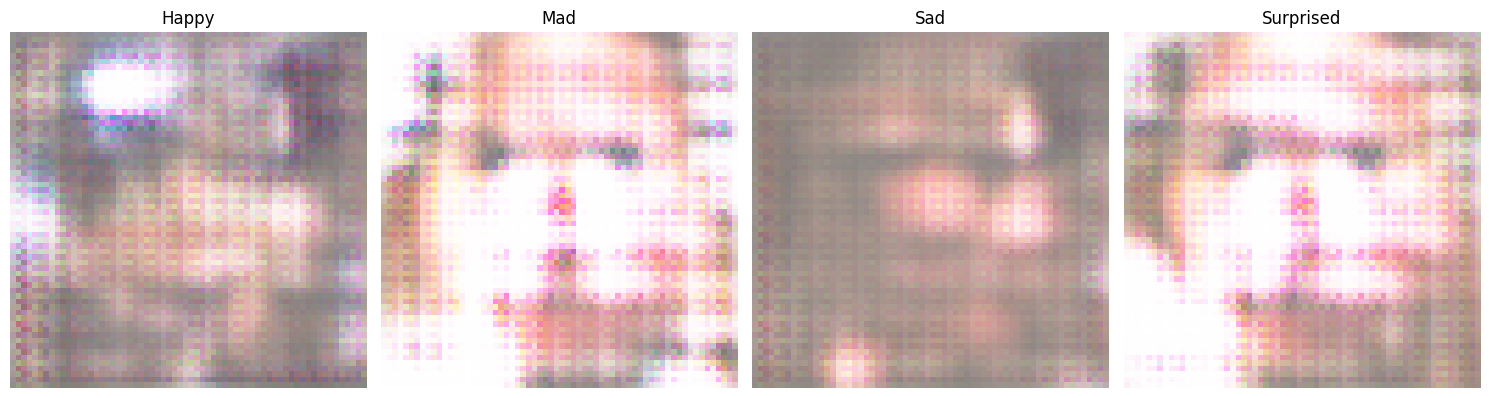


Epoch 151/200
  Generator Loss: 3.3778 | Discriminator Loss: 0.1812

Epoch 152/200
  Generator Loss: 3.7761 | Discriminator Loss: 0.1748

Epoch 153/200
  Generator Loss: 3.7844 | Discriminator Loss: 0.1335

Epoch 154/200
  Generator Loss: 3.2932 | Discriminator Loss: 0.1283

Epoch 155/200
  Generator Loss: 3.6735 | Discriminator Loss: 0.3100

Epoch 156/200
  Generator Loss: 4.1106 | Discriminator Loss: 0.1299

Epoch 157/200
  Generator Loss: 2.8596 | Discriminator Loss: 0.2293

Epoch 158/200
  Generator Loss: 3.8581 | Discriminator Loss: 0.2257

Epoch 159/200
  Generator Loss: 3.8837 | Discriminator Loss: 0.2172

Epoch 160/200
  Generator Loss: 2.8343 | Discriminator Loss: 0.2082


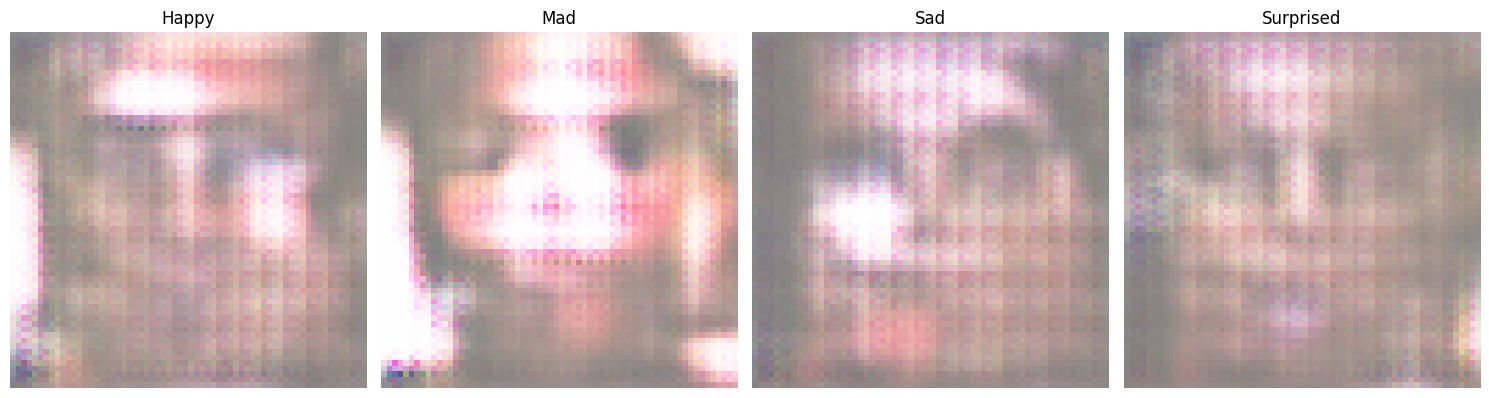


Epoch 161/200
  Generator Loss: 3.8147 | Discriminator Loss: 0.0256

Epoch 162/200
  Generator Loss: 3.4648 | Discriminator Loss: 0.0922

Epoch 163/200
  Generator Loss: 3.5786 | Discriminator Loss: 0.2285

Epoch 164/200
  Generator Loss: 3.4984 | Discriminator Loss: 0.1821

Epoch 165/200
  Generator Loss: 3.4302 | Discriminator Loss: 0.1066

Epoch 166/200
  Generator Loss: 4.5878 | Discriminator Loss: 0.0891

Epoch 167/200
  Generator Loss: 3.7813 | Discriminator Loss: 0.0797

Epoch 168/200
  Generator Loss: 3.9238 | Discriminator Loss: 0.0714

Epoch 169/200
  Generator Loss: 2.8864 | Discriminator Loss: 0.1313

Epoch 170/200
  Generator Loss: 4.0116 | Discriminator Loss: 0.2461


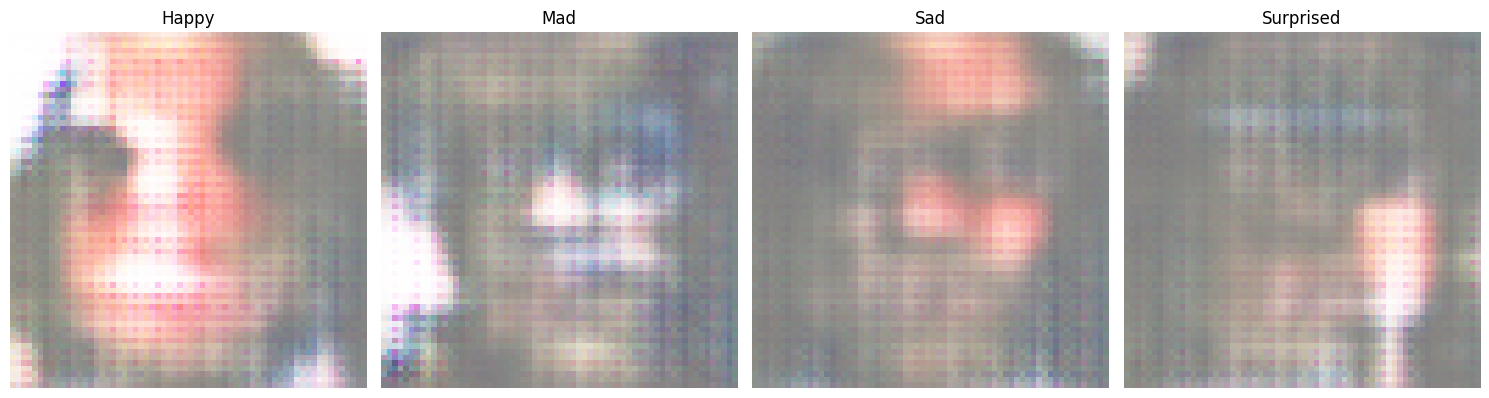


Epoch 171/200
  Generator Loss: 3.6200 | Discriminator Loss: 0.0467

Epoch 172/200
  Generator Loss: 3.8617 | Discriminator Loss: 0.1122

Epoch 173/200
  Generator Loss: 3.3947 | Discriminator Loss: 0.1467

Epoch 174/200
  Generator Loss: 2.7697 | Discriminator Loss: 0.1641

Epoch 175/200
  Generator Loss: 3.4472 | Discriminator Loss: 0.1452

Epoch 176/200
  Generator Loss: 4.6246 | Discriminator Loss: 0.0964

Epoch 177/200
  Generator Loss: 3.5757 | Discriminator Loss: 0.0773

Epoch 178/200
  Generator Loss: 2.7445 | Discriminator Loss: 0.1638

Epoch 179/200
  Generator Loss: 3.4944 | Discriminator Loss: 0.1147

Epoch 180/200
  Generator Loss: 2.5978 | Discriminator Loss: 0.1633


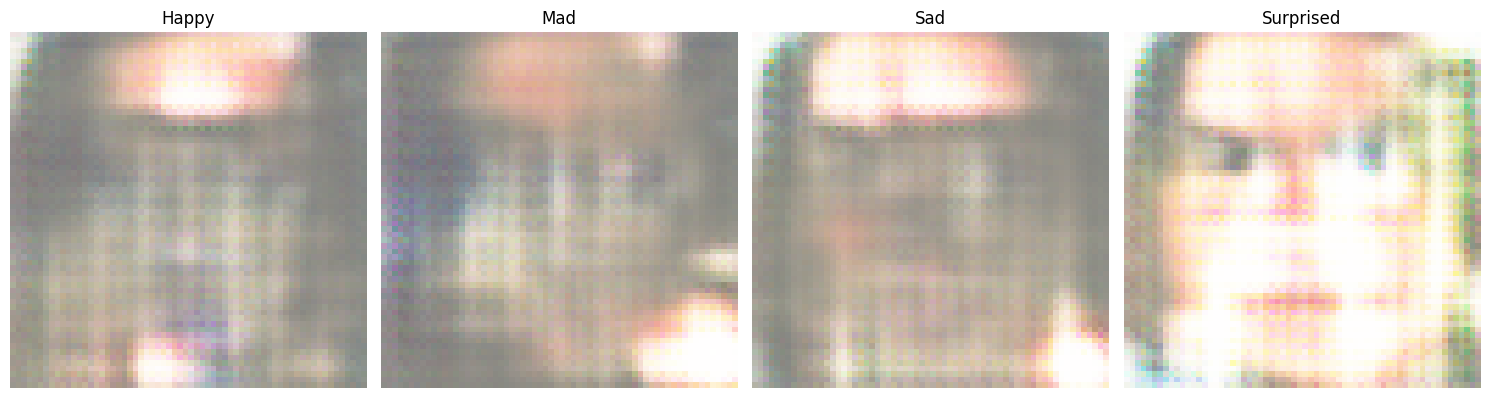


Epoch 181/200
  Generator Loss: 4.0382 | Discriminator Loss: 0.1195

Epoch 182/200
  Generator Loss: 3.5695 | Discriminator Loss: 0.0671

Epoch 183/200
  Generator Loss: 2.3488 | Discriminator Loss: 0.1476

Epoch 184/200
  Generator Loss: 3.1775 | Discriminator Loss: 0.1254

Epoch 185/200
  Generator Loss: 3.2255 | Discriminator Loss: 0.0862

Epoch 186/200
  Generator Loss: 3.2971 | Discriminator Loss: 0.1771

Epoch 187/200
  Generator Loss: 3.2298 | Discriminator Loss: 0.1950

Epoch 188/200
  Generator Loss: 4.2657 | Discriminator Loss: 0.0921

Epoch 189/200
  Generator Loss: 3.5969 | Discriminator Loss: 0.0674

Epoch 190/200
  Generator Loss: 3.2680 | Discriminator Loss: 0.1613


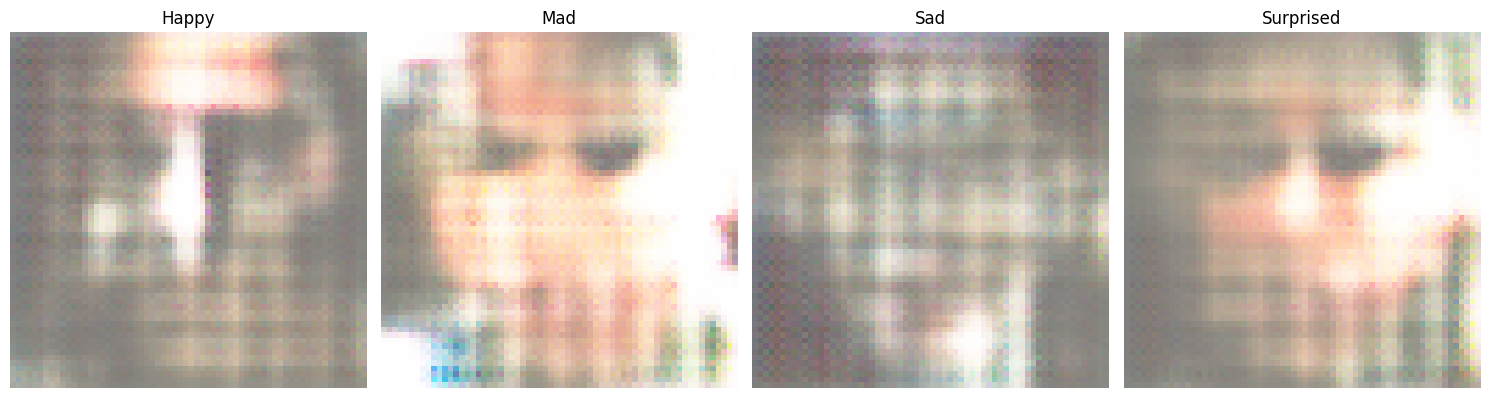


Epoch 191/200
  Generator Loss: 3.2337 | Discriminator Loss: 0.1091

Epoch 192/200
  Generator Loss: 3.1529 | Discriminator Loss: 0.1061

Epoch 193/200
  Generator Loss: 3.9071 | Discriminator Loss: 0.1200

Epoch 194/200
  Generator Loss: 3.8587 | Discriminator Loss: 0.0272

Epoch 195/200
  Generator Loss: 3.2344 | Discriminator Loss: 0.1009

Epoch 196/200
  Generator Loss: 3.5663 | Discriminator Loss: 0.1943

Epoch 197/200
  Generator Loss: 3.4520 | Discriminator Loss: 0.0917

Epoch 198/200
  Generator Loss: 4.3166 | Discriminator Loss: 0.1667

Epoch 199/200
  Generator Loss: 4.4271 | Discriminator Loss: 0.2249

Epoch 200/200
  Generator Loss: 4.0646 | Discriminator Loss: 0.0633


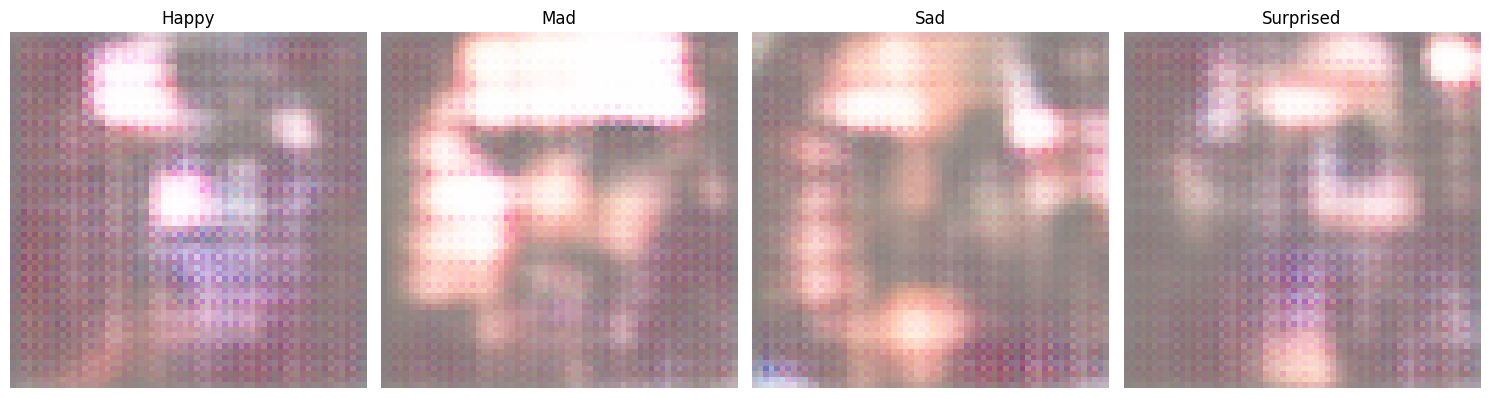

In [7]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# E.g., defined earlier:
# generator, discriminator, train_step, train_data, z_dim, NUM_CLASSES, label_names

EPOCHS = 200
sample_labels = tf.eye(NUM_CLASSES)
MAX_BATCHES = 30  # Limit batches per epoch for faster training

# Create save directories for both models
os.makedirs("saved_generators", exist_ok=True)
os.makedirs("saved_discriminators", exist_ok=True)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    batch_count = 0

    for image_batch, label_batch in train_data:
        g_loss, d_loss = train_step(image_batch, label_batch)
        batch_count += 1
        if batch_count >= MAX_BATCHES:
            break

    print(f"  Generator Loss: {g_loss.numpy():.4f} | Discriminator Loss: {d_loss.numpy():.4f}")

    # Save models and plot generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        # Generate and plot images
        noise = tf.random.normal([NUM_CLASSES, z_dim])
        generated_imgs = generator([noise, sample_labels], training=False)
        grid = np.clip((generated_imgs.numpy() + 1) / 2.0, 0, 1)

        fig, axs = plt.subplots(1, NUM_CLASSES, figsize=(15, 4))
        for i in range(NUM_CLASSES):
            axs[i].imshow(grid[i])
            axs[i].axis('off')
            axs[i].set_title(label_names[i])
        plt.tight_layout()
        plt.show()

        # Save both generator and discriminator
        generator.save(f"saved_generators/generator_epoch_{epoch+1}.h5")
        discriminator.save(f"saved_discriminators/discriminator_epoch_{epoch+1}.h5")


In [8]:
# Save generator and discriminator to disk
generator.save("saved_models/cgan_generator.h5")
discriminator.save("saved_models/cgan_discriminator.h5")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 104)       │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16384)     │  1,703,936 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 256) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    819,328 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    204,864 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64, 3) │      4,803 │ conv2d_transpose… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,732,931 (10.43 MB)

 Trainable params: 2,732,931 (10.43 MB)

 Non-trainable params: 0 (0.00 B)

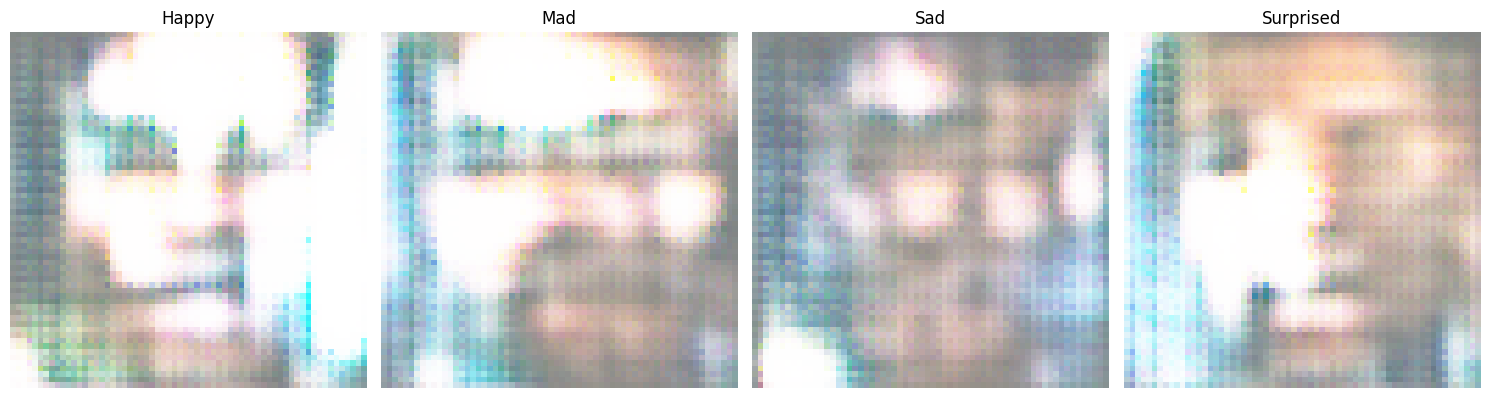

In [9]:
# Generate conditional samples for each class
def generate_and_plot(generator, z_dim, label_names):
    generator.summary()  # Optional: See the model summary
    NUM_CLASSES = len(label_names)
    noise = tf.random.normal([NUM_CLASSES, z_dim])
    sample_labels = tf.eye(NUM_CLASSES)  # One-hot vectors

    generated_imgs = generator([noise, sample_labels], training=False)
    grid = np.clip((generated_imgs.numpy() + 1) / 2.0, 0, 1)

    plt.figure(figsize=(15, 4))
    for i in range(NUM_CLASSES):
        plt.subplot(1, NUM_CLASSES, i + 1)
        plt.imshow(grid[i])
        plt.axis('off')
        plt.title(label_names[i])
    plt.tight_layout()
    plt.show()

# Example usage:
generate_and_plot(generator, z_dim, label_names)


In [10]:
def save_generated_images(generator, z_dim, label_names, output_dir="generated_images"):
    os.makedirs(output_dir, exist_ok=True)
    NUM_CLASSES = len(label_names)
    noise = tf.random.normal([NUM_CLASSES, z_dim])
    sample_labels = tf.eye(NUM_CLASSES)

    generated_imgs = generator([noise, sample_labels], training=False)
    generated_imgs = ((generated_imgs + 1) * 127.5).numpy().astype(np.uint8)

    for i, img_array in enumerate(generated_imgs):
        img = Image.fromarray(img_array)
        img.save(os.path.join(output_dir, f"{label_names[i]}.png"))

    print(f"Images saved to: {output_dir}")

# Example:
save_generated_images(generator, z_dim, label_names)


Images saved to: generated_images
